### ==== Encoding and Decoding the speech samples ====

In [2]:
# @Author: Gebremichael
# @File: dialogic_ADPCM.py 
import wave
import numpy as np

# table of index
IndexTable = [-1, -1, -1, -1, 2, 4, 6, 8, -1, -1, -1, -1, 2, 4, 6, 8]

# table of  quantizer step size
StepSizeTable = [7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 19, 21, 23, 25, 28, 31, 34, 37, 41, 45, 50, 55, 60, 66, 73, 80, 88, 97, 107, 118, 130, 143, 157, 173, 190, 209, 230, 253, 279, 307, 337, 371, 408, 449, 494, 544, 598, 658, 724, 796, 876, 963, 1060, 1166, 1282, 1411, 1552, 1707, 1878, 2066, 2272, 2499, 2749, 3024, 3327, 3660, 4026, 4428, 4871, 5358, 5894, 6484, 7132, 7845, 8630, 9493, 10442, 11487, 12635, 13899, 15289, 16818, 18500, 20350, 22385, 24623, 27086, 29794, 32767]

# ADPCM_Encode.
# sample: a 16-bit PCM sample
# retval : a 4-bit ADPCM sample
predsample = 0
index = 0

# # ======================================================================================
# Encoding from PCM to ADPCM (16-bit PCM sample to 4-bit ADPCM  sample word length)
def ADPCM_Encode(sample):
    global index
    global predsample
    global diffq
    global ore_diff
    global error_signal
    
    code = 0
    
    step_size = StepSizeTable[index]

    # compute diff and record sign and absolut value
          
    diff = sample - predsample
    ore_diff=diff
    #print('diff sample:' ,ore_diff)
    if diff < 0:
        code = 8
        diff = -diff

    # quantize the diff into ADPCM code
    # inverse quantize the code into a predicted diff
    tmpstep = step_size
    diffq = step_size >> 3
    if diff >= tmpstep:
        code = code | 0x04
        diff -= tmpstep
        diffq = diffq + step_size

    tmpstep = tmpstep >> 1
    if diff >= tmpstep:
        code = code | 0x02
        diff = diff - tmpstep
        diffq = diffq + (step_size >> 1)

    tmpstep = tmpstep >> 1
    if diff >= tmpstep:
        code = code | 0x01
        diffq = diffq + (step_size >> 2)
    
    # fixed predictor to get new predicted sample
    if code & 8:
        predsample = predsample - diffq
    else:
        predsample = predsample + diffq
         
    # check for overflow
    if predsample > 32767:
        predsample = 32767
    elif predsample < -32768:
        predsample = -32768

    # find new stepsize index
    index += IndexTable[code]

    # check for overflow
    if index < 0:
        index = 0

    if index > 88:
        index = 88
    error_signal = sample - predsample
    
    # return new ADPCM code code & 0x0f == code
    return code & 0x0f


# ADPCM_Decode.
# code: a byte containing a 4-bit ADPCM sample.
# retval: 16-bit ADPCM sample
de_index = 0
de_predsample = 0

# ======================================================================================
# Decoding from ADPCM to PCM  ( a 4-bit ADPCM sample to 16-bit PCM sample word length)
def ADPCM_Decode(code):
    global de_index
    global de_predsample

    step_size = StepSizeTable[de_index]

    # inverse code into diff    
    diffq = step_size >> 3  # == step/8
    if code & 4:
        diffq += step_size

    if code & 2:
        diffq += step_size >> 1

    if code & 1:
        diffq += step_size >> 2

       
    # add diff to predicted sample
    if code & 8:
        diffq = -diffq

    de_predsample += diffq

    # check for overflow  clip the values to +/- 2^11 (supposed to be 16 bits)
    if de_predsample > 32767:
        de_predsample = 32767
    elif de_predsample < -32768:
        de_predsample = -32768

    # find new quantizer step size
    de_index += IndexTable[code]

    # check for overflow
    if de_index < 0:
        de_index = 0

    if de_index > 88:
        de_index = 88

    # save predict sample and de_index for next iteration
    # return new decoded sample
    # The original algorithm turned out to be 12bit, need to convert to 16bit
    return de_predsample

In [3]:
import matplotlib.pyplot as plt
#%pmatplotlib inline
import IPython.display as ipd
import librosa
import librosa.display
import numpy as np
# Plotting package
import matplotlib.pyplot as plt

# ===============Different Data loading==============
# ...............scipy wave based data..............
import wave
from scipy.io import wavfile
np.set_printoptions(threshold=np.inf)
audio_file = 'audio_data/Test_dataset_All_4_speakers_merged_MS_and_FS.wav'
fs, data = wavfile.read(audio_file)
wavdata=data[::]

# .................librosa based data..............
#audio, fs = librosa.load(audio_file, sr = 8000)
#wavdata=audio[:]

org_samp=[]
pre_samp=[]
oreginal_diff=[]
adpcm_code = []
q_diff=[]
err_signal=[]

for i in range(len(wavdata)):
    ADPCM_sample = ADPCM_Encode(wavdata[i])   
    pred_sample = ADPCM_Decode(ADPCM_sample)
    #print("Sample:", wavdata[i])
    #print("ADPCM code:", sample)
    #print('................................')
    
    org_samp.append(wavdata[i])
    pre_samp.append(pred_sample)
    oreginal_diff.append(ore_diff)
    q_diff.append(diffq)
    err_signal.append(error_signal)
    
org_samp=np.array(org_samp)           #oreginal signal samples
pre_samp=np.array(pre_samp)           #predicted sample 

oreginal_diff=np.array(oreginal_diff) #the oreginal and predicted sample difference
adpcm_code = np.array(adpcm_code)     #the ADPCM code the is transmited to decoder 
q_diff = np.array(q_diff)             #the quantized difference/inverse of quantization difference
e_signal=np.array(err_signal)         #the error of the prediction (residual signal)

In [7]:
# Normalize Data Between 0 and 1
y = org_samp
ypn = pre_samp

org_samp = np.array(y)
# goal : range [0, 1]
org_samp = (org_samp - min(org_samp)) / ( max(org_samp) - min(org_samp) )

pre_samp = np.array(ypn)
pre_samp = (pre_samp - min(pre_samp)) / ( max(pre_samp) - min(pre_samp) )

In [4]:
# ===============Step 0: Data Preparation==============
# Need the data to be in the form [sample, time steps, features (dimension of each element)]
samples = 10 # Number of samples (in past)
steps = 1 # Number of steps (in future)
X = [] # X array
Y = [] # Y array

for i in range(wavdata.shape[0] - samples): 
    X.append(pre_samp[i:i+samples]) # Independent Samples
    Y.append(org_samp[i+samples-1]) # Dependent Samples
X = np.array(X)
X = np.expand_dims(X, axis=2)

Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

print('Training Data: Length is ',len(X[0:1][0]),': ', X[0:1])
print('Testing Data: Length is ', len(Y[0:1]),': ', Y[0:1])

print('Dimensions of X:', X.shape) 
print('Dimensions of Y:', Y.shape)

# threshold = round(0.9 * X.shape[0])
# print('Threshold is', threshold)

Training Data: Length is  10 :  [[[-1]
  [-2]
  [-1]
  [ 2]
  [ 5]
  [ 4]
  [ 0]
  [-1]
  [ 2]
  [ 6]]]
Testing Data: Length is  1 :  [[7]]
Dimensions of X: (995530, 10, 1)
Dimensions of Y: (995530, 1)


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# =================build GRU Architectur========================
# Let's build the GRU
model = keras.Sequential()

# Add a GRU layer with 3 units.
model.add(layers.GRU(3,
                     activation = "tanh",
                     recurrent_activation = "sigmoid",
                     input_shape=(X.shape[1], X.shape[2])))
# Add a dropout layer (penalizing more complex models) -- prevents overfitting
model.add(layers.Dropout(rate=0.2))


# Add a Dense layer with 1 units (Since we are doing a regression task.
model.add(layers.Dense(1))

# Evaluating loss function of MSE using the adam optimizer.
model.compile(loss='mean_squared_error', optimizer = 'adam')

# Print out architecture.
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3)                 54        
                                                                 
 dropout (Dropout)           (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 58
Trainable params: 58
Non-trainable params: 0
_________________________________________________________________


In [10]:
#============Training the model with the given inputs==============
history = model.fit(X[:],
                    Y[:],
                    
                    shuffle = False, # Since this is time series data
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1) # Verbose outputs data

Epoch 1/50
24889/24889 [==============================] - 250s 10ms/step - loss: 0.0017 - val_loss: 6.5622e-05
Epoch 2/50
24889/24889 [==============================] - 236s 9ms/step - loss: 1.8731e-04 - val_loss: 5.9957e-05
Epoch 3/50
24889/24889 [==============================] - 229s 9ms/step - loss: 1.6595e-04 - val_loss: 5.3217e-05
Epoch 4/50
24889/24889 [==============================] - 256s 10ms/step - loss: 1.5322e-04 - val_loss: 5.1213e-05
Epoch 5/50
24889/24889 [==============================] - 236s 9ms/step - loss: 1.4170e-04 - val_loss: 3.6420e-05
Epoch 6/50
24889/24889 [==============================] - 251s 10ms/step - loss: 1.3389e-04 - val_loss: 3.1604e-05
Epoch 7/50
24889/24889 [==============================] - 247s 10ms/step - loss: 1.3100e-04 - val_loss: 3.3956e-05
Epoch 8/50
24889/24889 [==============================] - 248s 10ms/step - loss: 1.3196e-04 - val_loss: 2.9041e-05
Epoch 9/50
24889/24889 [==============================] - 239s 10ms/step - loss: 1.3229

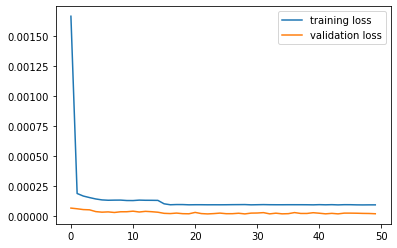

In [11]:
# ==========================Plotting the loss iteration===========================
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label ='validation loss')
plt.legend()
# Note:
# if training loss >> validation loss -> Underfitting
# if training loss << validation loss -> Overfitting (i.e model is smart enough to have mapped the entire dataset..)
# Several ways to address overfitting:
# Reduce complexity of model (hidden layers, neurons, parameters input etc)
# Add dropout and tune rate
# More data :)

In [12]:
# to save the trained model
# https://www.youtube.com/watch?v=vJWbSTJYXGM&t=236s 
model.save('G_ADPCM_GRU_speech_coding_trained_model_Adam_epoch_50_length_of_step_15.h5')